In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL  
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DATASET = "/kaggle/input/dataset-final/2750/"
LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


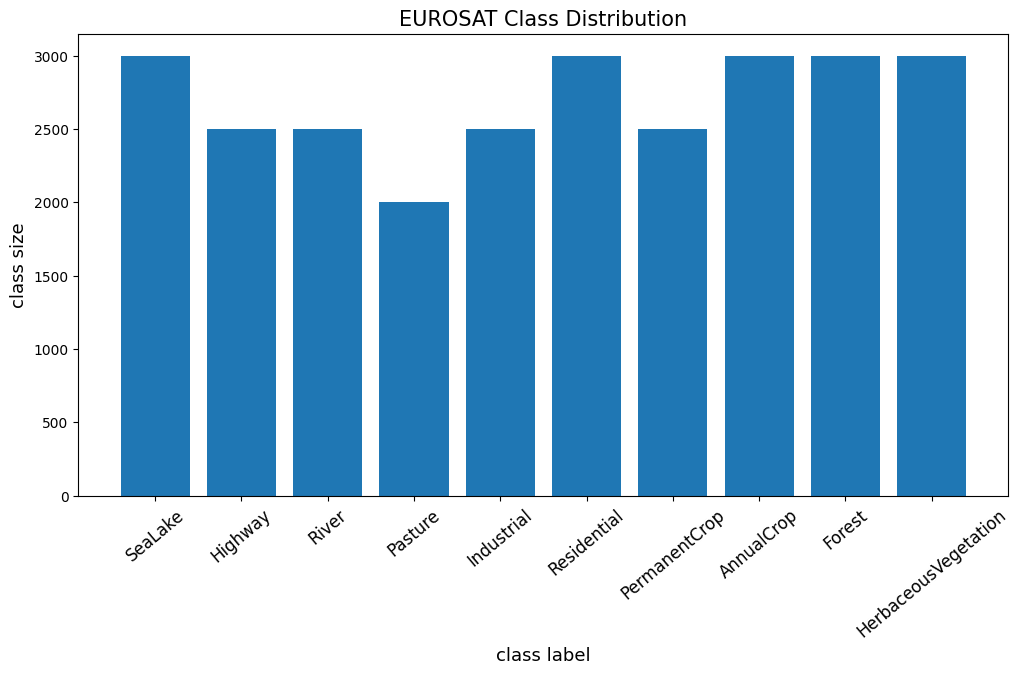

In [4]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [5]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

2024-03-24 16:46:15.788048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 16:46:15.788205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 16:46:15.972947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import os
import re
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DATASET = '/kaggle/input/dataset-final/2750'
TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
LABELS = os.listdir(DATASET)  # Assuming each subdirectory in DATASET corresponds to a class

# Map each image path to its class label in 'data'
data = {}
for l in LABELS:
    for img in os.listdir(os.path.join(DATASET, l)):
        data[os.path.join(DATASET, l, img)] = l

# Convert the mapping to pandas Series
X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

# Perform stratified split
train_paths, test_paths, _, _ = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

# Define new paths for training and testing
new_train_paths = [re.sub(DATASET, TRAIN_DIR, path) for path in train_paths]
new_test_paths = [re.sub(DATASET, TEST_DIR, path) for path in test_paths]

# Move files to training directory
print("Moving training files...")
for source, destination in tqdm(zip(train_paths, new_train_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

# Move files to testing directory
print("Moving testing files...")
for source, destination in tqdm(zip(test_paths, new_test_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

Moving training files...


21600it [01:12, 296.90it/s]


Moving testing files...


5400it [00:18, 298.73it/s]


In [7]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)
#This code block is using the flow_from_directory method of the ImageDataGenerator instance to generate batches of tensor image data from a directory. Here's a breakdown of each parameter:
train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
#The flow_from_directory method returns a DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)


{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.applications import ResNet50
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='gelu', input_shape=input_shape))
    #model.add(Conv2D(16, (3, 3), activation='gelu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='gelu'))
    #model.add(Conv2D(32, (3, 3), activation='gelu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3, 3), activation='gelu'))
    #model.add(Conv2D(64, (3, 3), activation='gelu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(10, activation='softmax'))  # Assuming softmax for classification

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model



In [11]:
p_model = compile_model( INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
# p_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 10
print(N_STEPS)
print(N_VAL_STEPS)
# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.best.keras',
                              monitor='val_categorical_accuracy',
                              save_best_only=True,
                              verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

337
84


In [13]:
p_history = p_model.fit(train_generator,steps_per_epoch=N_STEPS,epochs=20,
                                      callbacks=[early_stop, checkpoint],
                                      validation_data=test_generator,
                                      validation_steps=N_VAL_STEPS)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - categorical_accuracy: 0.1231 - loss: 18.0646
Epoch 1: val_categorical_accuracy improved from -inf to 0.19475, saving model to ../working/model.best.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 128s 366ms/step - categorical_accuracy: 0.1232 - loss: 18.0340 - val_categorical_accuracy: 0.1948 - val_loss: 1.9892
Epoch 2/20
  1/337 ━━━━━━━━━━━━━━━━━━━━ 1:40 301ms/step - categorical_accuracy: 0.1406 - loss: 1.9705

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_categorical_accuracy improved from 0.19475 to 0.20833, saving model to ../working/model.best.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.1406 - loss: 0.9882 - val_categorical_accuracy: 0.2083 - val_loss: 1.0346
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - categorical_accuracy: 0.2352 - loss: 1.8996
Epoch 3: val_categorical_accuracy improved from 0.20833 to 0.24554, saving model to ../working/model.best.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 120s 354ms/step - categorical_accuracy: 0.2353 - loss: 1.8995 - val_categorical_accuracy: 0.2455 - val_loss: 1.9568
Epoch 4/20
  1/337 ━━━━━━━━━━━━━━━━━━━━ 1:37 289ms/step - categorical_accuracy: 0.2500 - loss: 1.9680
Epoch 4: val_categorical_accuracy did not improve from 0.24554
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - categorical_accuracy: 0.2500 - loss: 0.9869 - val_categorical_accuracy: 0.0833 - val_loss: 1.1719
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - categorical_accuracy: 0.250

In [14]:
def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

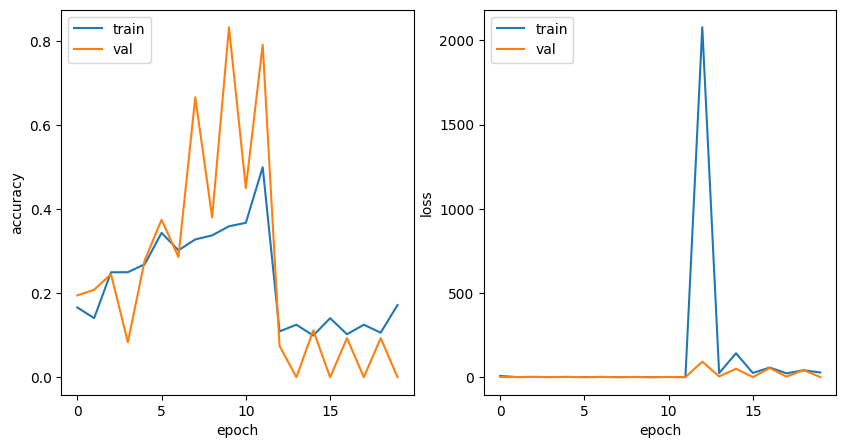

In [15]:
plot_history(p_history)

In [16]:
from keras.models import load_model

proposed_model = load_model('../working/model.best.keras')

# Print the summary of the loaded model to check its architecture
proposed_model.summary()

class_indices = train_generator.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

# Use the predict method directly instead of predict_generator
predictions = proposed_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,287,184 (8.72 MB)

 Trainable params: 762,394 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,524,790 (5.82 MB)

Found 5400 images belonging to 10 classes.
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step
Accuracy: 0.23314814814814816
Global F2 Score: 0.23314814814814816


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.137146,0.983333,0.240718,600.0
Forest,0.737991,0.281667,0.407720,600.0
HerbaceousVegetation,0.000000,0.000000,0.000000,600.0
Highway,0.000000,0.000000,0.000000,500.0
Industrial,0.000000,0.000000,0.000000,500.0
Pasture,0.000000,0.000000,0.000000,400.0
PermanentCrop,0.000000,0.000000,0.000000,500.0
Residential,0.000000,0.000000,0.000000,600.0
River,0.954545,0.042000,0.080460,500.0
SeaLake,0.565525,0.798333,0.662059,600.0


In [17]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,590,4,0,0,0,0,0,0,0,6
Forest,151,169,0,0,0,0,0,0,0,280
HerbaceousVegetation,536,1,0,0,0,0,0,0,0,63
Highway,500,0,0,0,0,0,0,0,0,0
Industrial,500,0,0,0,0,0,0,0,0,0
Pasture,366,27,0,0,0,0,0,0,1,6
PermanentCrop,497,0,0,0,0,0,0,0,0,3
Residential,599,0,0,0,0,0,0,0,0,1
River,465,5,0,0,0,0,0,0,21,9
SeaLake,98,23,0,0,0,0,0,0,0,479


In [18]:
proposed_model.save('/kaggle/working/models/proposed_eurosat.h5')

In [19]:
import shap

In [20]:
masker = shap.maskers.Image('inpaint_telea',test_generator_new.image_shape)

In [21]:
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return denseNet121_model(tmp)

In [36]:
class_names = list(test_generator_new.class_indices.keys())
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [37]:
explainer = shap.Explainer(proposed_model, masker, output_names=class_names)
explainer

In [41]:
test_gen_list =[]
i=0
for batch in test_generator_new:
    if i<10:
        test_gen_list.append(batch[0])
        i=i+1
    else:
        break
test_gen_array = np.array(test_gen_list)

In [42]:
shap_values = explainer(
    test_gen_array[1:9] , max_evals=500, batch_size=64, outputs=shap.Explanation.argsort.flip[:1]
)

PartitionExplainer explainer: 9it [00:23,  4.62s/it]                       


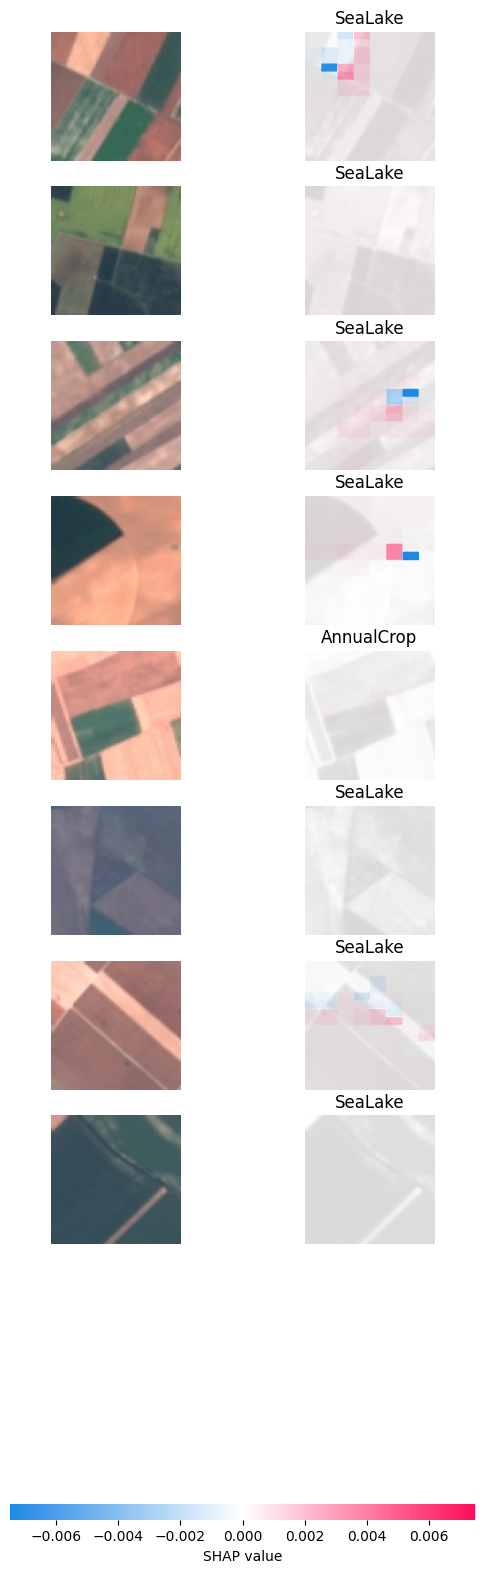

In [43]:
shap.image_plot(shap_values)

In [47]:
masker2 = shap.maskers.Image('inpaint_telea',test_generator_new.image_shape)

In [48]:
exp2 = shap.Explainer(proposed_model, masker2, output_names=class_names)

In [49]:
shap_val2 = exp2(test_gen_array[1:9])

PartitionExplainer explainer: 9it [00:35,  5.89s/it]                       


(3, 10)


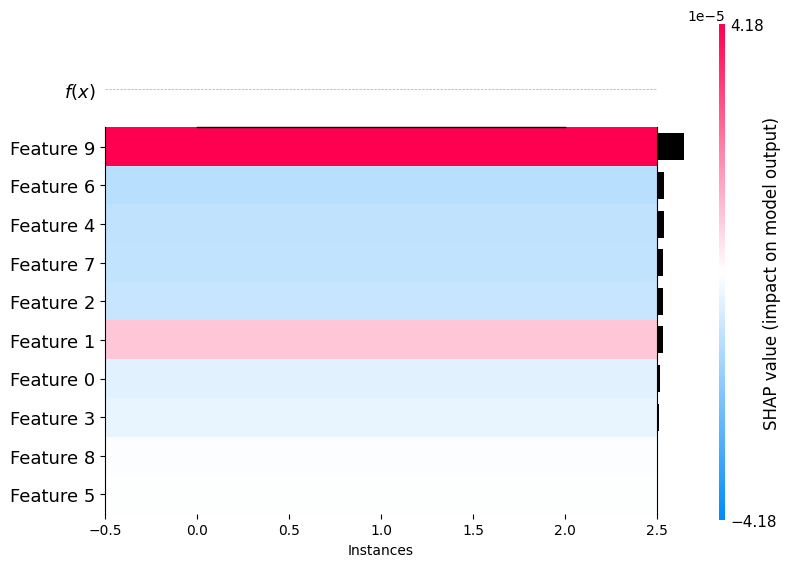

In [50]:
# Select all values from the 4th and 5th dimensions and take the mean along the first three dimensions
shap_val4_2d = shap_val2[...,:, :].mean(axis=(0, 1, 2))

# Now shap_val4_2d should be a 2D array
print(shap_val4_2d.shape)

# Plot the heatmap
shap.plots.heatmap(shap_val4_2d)

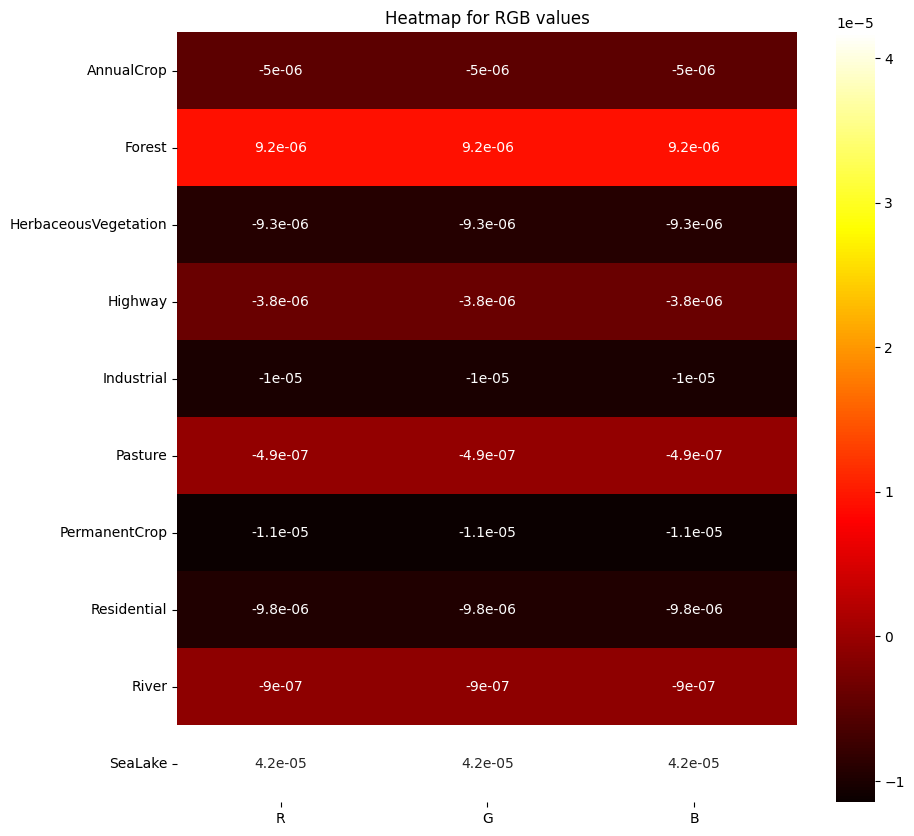

In [53]:
import numpy as np
import seaborn as sns
import pandas as pd

# Assuming shap_values is a 5D array (samples, height, width, channels, classes)
# We take the average over the samples and spatial dimensions to get a 2D array
avg_shap_values = shap_val2.values.mean(axis=(0, 1, 2))

# Convert the 2D array to a DataFrame for easier plotting
df = pd.DataFrame(avg_shap_values.T, columns=['R', 'G', 'B'], index=class_names)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True
            , cmap='hot')
plt.title('Heatmap for RGB values')
plt.show()